# Import required libraries - PyTorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

# Data Preprocessing

In [2]:
def load_horses_orig(path, image_size):   
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
    
        images.append(low_im)
        masks.append(bin_mask)
        
        xtest = np.array(images[250:])
        ytest = np.array(masks[250:])
        xdata = np.array(images[:200])
        ydata = np.array(masks[:200])
        yval =  np.array(masks[200:250])
        xval = np.array(images[200:250])
        
    return xdata, xval, xtest, ydata, yval, ytest

In [3]:
path = 'horses/'
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

# Normalise

##### Dividing it by 255 and reducing RGB to Grayscale

In [4]:
gry = np.mean(np.array(xdata[0])/225, axis=2)

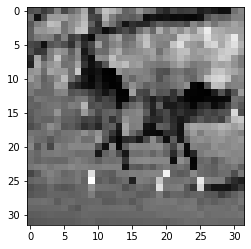

In [5]:
plt.imshow(gry, cmap = "gray")

# Loss Function

In [6]:
# BATCH_SIZE = 1

def loss_function(recon_x, x, mu, logvar) -> Variable:
    recon_loss = nn.BCELoss(reduction='mean')
    BCE = recon_loss(recon_x, x.view(-1, 1024))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# CVAE Model

In [58]:
n_hidden, z_dim = 1024, 2
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

#         # Encoder Layer
#         self.fc1 = nn.Linear(2048, 400) #Input Size x Hidden Size
#         self.relu = nn.ReLU()
#         self.fc21 = nn.Linear(400, 20) #Hidden Size x Latent Size
#         self.fc22 = nn.Linear(400, 20) #Hidden Size x Latent Size
        

#         # Decoder Layer
#         self.fc3 = nn.Linear(1044, 400) #Input Size + Latent Size x Hidden Size
#         self.fc4 = nn.Linear(400, 1024) #Hidden Size x Output Size
#         self.sigmoid = nn.Sigmoid()

        # Encoder Layer
        self.fc1 = nn.Linear(2048, n_hidden) #Input Size x Hidden Size
        self.relu = nn.ReLU()
        self.d1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(n_hidden, n_hidden//2) #Input Size x Hidden Size
        self.d2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(n_hidden//2, n_hidden//4) #Input Size x Hidden Size
        self.d3 = nn.Dropout(0.1)
        self.fl = nn.Linear(n_hidden//4, z_dim)

        # Decoder Layer
        self.fc4 = nn.Linear(1026, n_hidden//4)
        self.d4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(n_hidden//4, n_hidden//2)
        self.d5 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(n_hidden//2, 1024)
        self.d6 = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()
    
    
    def encode(self, x: Variable, y:Variable) -> (Variable, Variable):
#         print(type(x))
#         print(type(y))
#         x = torch.cat((x.float(), y.float()), dim=0)
        x = torch.cat([x,y],1)
        h1 = self.d1(self.relu(self.fc1(x)))
        h2 = self.d2(self.relu(self.fc2(h1)))
        h3 = self.d3(self.relu(self.fc3(h2)))
        mu = self.relu(self.fl(h3))
        log_var = self.relu(self.fl(h3))
        
        return mu, log_var

    def decode(self, z: Variable, y:Variable) -> (Variable, Variable):
#         z = torch.cat((z.float(), y.float()), dim=0)
        z = torch.cat([z,y], 1)
        h4 = self.d4(self.relu(self.fc4(z)))
        h5 = self.d5(self.relu(self.fc5(h4)))
        h6 = self.d6(self.relu(self.fc6(h5)))
        return self.sigmoid(h6)
    
#     def encode(self, x: Variable, y:Variable) -> (Variable, Variable):
#         x = torch.cat([x,y],1)
#         h1 = self.relu(self.fc1(x))  
#         return self.fc21(h1), self.fc22(h1)

#     def decode(self, z: Variable, y:Variable) -> (Variable, Variable):
#         z = torch.cat([z,y], 1)
#         h3 = self.relu(self.fc3(z))
#         return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable, y: Variable) -> (Variable, Variable, Variable):        
#         plt.imshow(x, cmap = "gray")
        mu, logvar = self.encode(x.view(-1,32*32), y.view(-1,32*32))
        #Reparameterization Trick
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
#         z = self.reparameterize(mu, logvar)
        return self.decode(z, x.view(-1,32*32)), mu, logvar, z
    
#     def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:

#         #mu :  mean matrix
#         #logvar :  variance matrix
#         if self.training: 
#             std = logvar.mul(0.5).exp_()  # type: Variable
#             eps = Variable(std.data.new(std.size()).normal_())
#             return eps.mul(std).add_(mu)
#         else:
#             return mu

In [8]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    division = intersect / (union+0.0)
#     division[np.isnan(division)] = 0
    
    return np.average(division)


In [9]:
# assert iou(temp1, temp1) == 1.0

# IOU

In [10]:
def calc_iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [64]:
model = VAE()
EPOCHS = 100
train_iou = []
val_iou = []
test_iou = []
best_val_iou = -1
best_test_iou = -1

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(epoch):
    model.train()
    train_loss = 0
#     batch = 0
    
    for i, j in enumerate(xdata):
#         batch = batch+1
        
        data = torch.from_numpy(np.mean(np.array(j)/255, axis=2))
        labels = torch.from_numpy(np.array(ydata[i])/255)
        labels = Variable(labels)
        data = Variable(data)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar, z_space = model(data.float(), labels.float())
#         if batch = 64
        loss = loss_function(recon_batch, labels.float(), mu, logvar)
        loss.backward()
#         print(loss.data)
        optimizer.step()

    return loss



# def test(z_space):
#     model.eval()
#     test_loss = 0
#     ydata_pred = []
#     for i, j in enumerate(xdata):
#         data = torch.from_numpy(np.mean(np.array(j)/255, axis=2))
#         data = Variable(data)
#         tt = np.array(ydata[i])/255

#         labels = torch.from_numpy(np.array(ydata[i])/255)
#         labels = Variable(labels)
#         cond_ = labels.float()
#         recon_batch = model.decode(z_space, cond_.view(-1,32*32))
        
#         t = recon_batch.detach().numpy()

#         if train_iou == []:
#             train_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
#         if train_iou != []:
#             if train_iou[len(train_iou)-1] < calc_iou(tt,t.reshape(-1,32,32)) or train_iou[len(train_iou)-1] == calc_iou(tt,t.reshape(-1,32,32)):
#                 train_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
        
#         ydata_pred.append(t)
    
#     yval_pred = []
#     for i, j in enumerate(xval):
#         data = torch.from_numpy(np.mean(np.array(j)/255, axis=2))
#         data = Variable(data)
#         tt = np.array(yval[i])/255
#         labels = torch.from_numpy(np.array(yval[i])/255)
#         labels = Variable(labels)
#         cond_ = labels.float()
#         recon_batch = model.decode(z_space, cond_.view(-1,32*32))
        
#         t = recon_batch.detach().numpy()
#         if val_iou == []:
#             val_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
#         if val_iou != []:
#             if val_iou[len(val_iou)-1] < calc_iou(tt,t.reshape(-1,32,32)) or val_iou[len(val_iou)-1] == calc_iou(tt,t.reshape(-1,32,32)):
#                 val_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
            
#         yval_pred.append(t)
    
#     ytest_pred = []
#     for i, j in enumerate(xtest):
#         data = torch.from_numpy(np.mean(np.array(j)/255, axis=2))
#         data = Variable(data)
#         tt = np.array(ytest[i])/255
#         labels = torch.from_numpy(np.array(ytest[i])/255)
#         labels = Variable(labels)
#         cond_ = labels.float()
#         recon_batch = model.decode(z_space, cond_.view(-1,32*32))
        
#         t = recon_batch.detach().numpy()
#         if test_iou == []:
#             test_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
#         if test_iou != []:
#             if test_iou[len(test_iou)-1] < calc_iou(tt,t.reshape(-1,32,32)) or test_iou[len(test_iou)-1] == calc_iou(tt,t.reshape(-1,32,32)):
#                 test_iou.append(calc_iou(tt,t.reshape(-1,32,32)))
        
#         ytest_pred.append(t)
    
#     ydata_pred = np.concatenate( ydata_pred, axis=0 )
#     yval_pred = np.concatenate( yval_pred, axis=0 )
#     ytest_pred = np.concatenate( ytest_pred, axis=0 )
    

#     return ydata_pred, train_iou, val_iou, test_iou

for epoch in range(1, EPOCHS + 1):
    loss = 0.0
    loss += train(epoch)
    print(loss)

#     if val_iou[-1] > best_val_iou:
#         best_test_iou = test_iou[-1]
#         best_val_iou = val_iou[-1]
#     display.clear_output(wait=False)
    
#     print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Test: {:0.3}".format( epoch, loss.data, train_iou[-1], best_test_iou))
    
#     fig, ax = plt.subplots(1,1)
#     pd.Series(train_iou).plot(ax=ax)
#     pd.Series(val_iou).plot(ax=ax)
#     pd.Series(test_iou).plot(ax=ax)
#     fig.canvas.draw()
    
    

tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6932, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<AddBackward0>)
tensor(0.6931, grad_fn=<A

KeyboardInterrupt: 

<ipython-input-65-f191d9132626>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


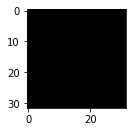

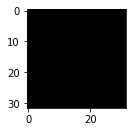

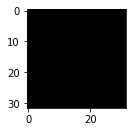

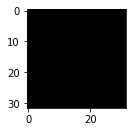

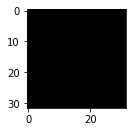

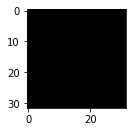

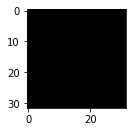

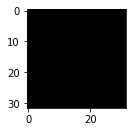

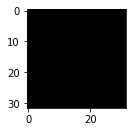

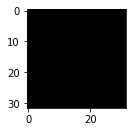

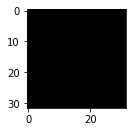

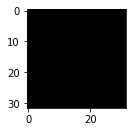

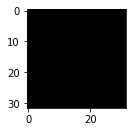

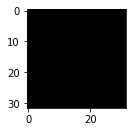

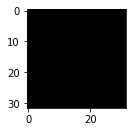

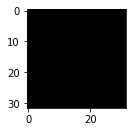

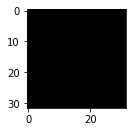

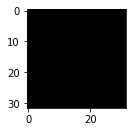

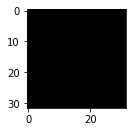

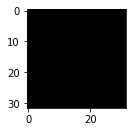

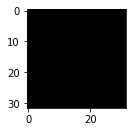

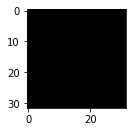

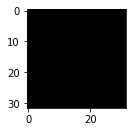

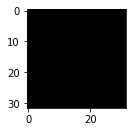

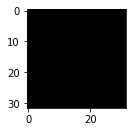

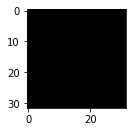

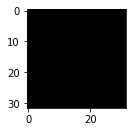

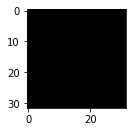

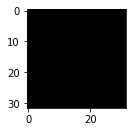

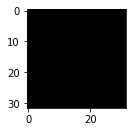

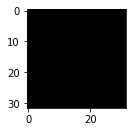

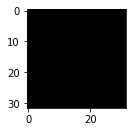

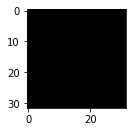

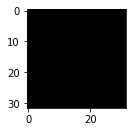

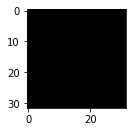

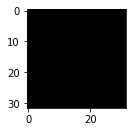

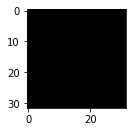

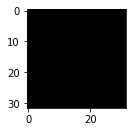

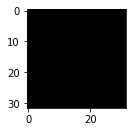

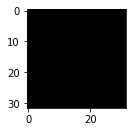

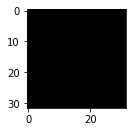

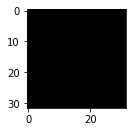

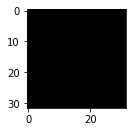

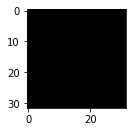

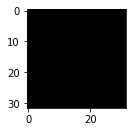

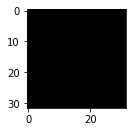

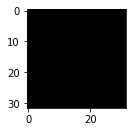

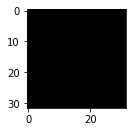

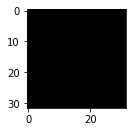

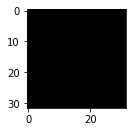

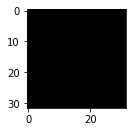

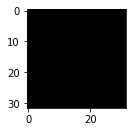

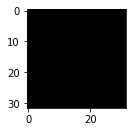

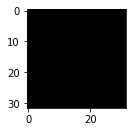

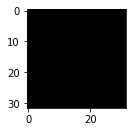

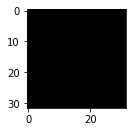

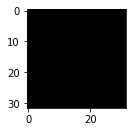

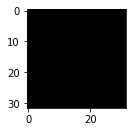

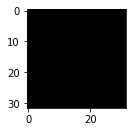

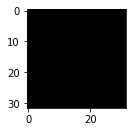

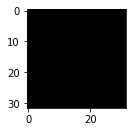

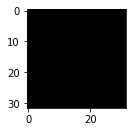

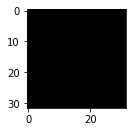

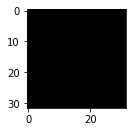

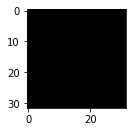

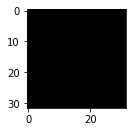

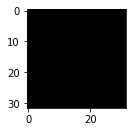

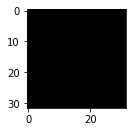

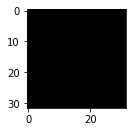

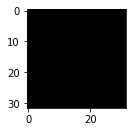

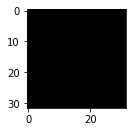

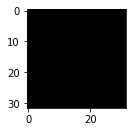

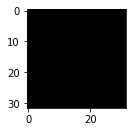

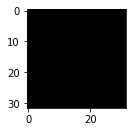

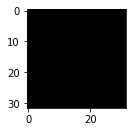

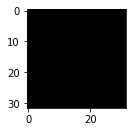

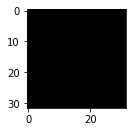

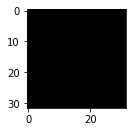

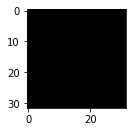

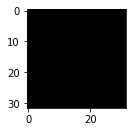

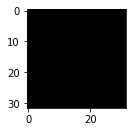

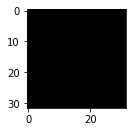

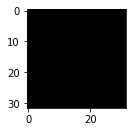

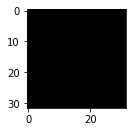

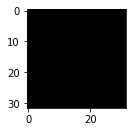

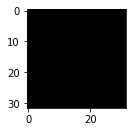

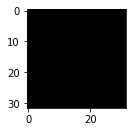

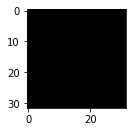

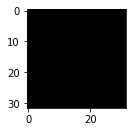

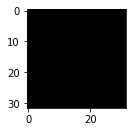

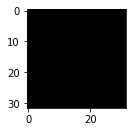

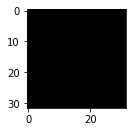

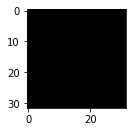

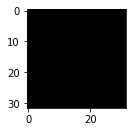

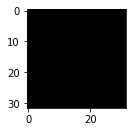

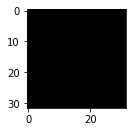

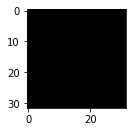

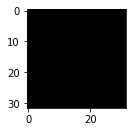

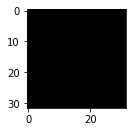

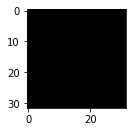

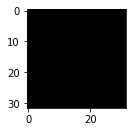

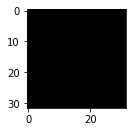

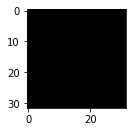

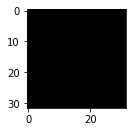

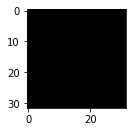

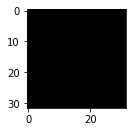

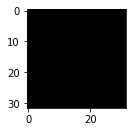

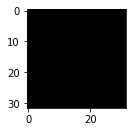

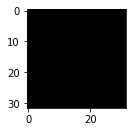

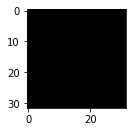

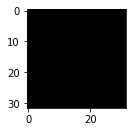

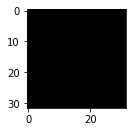

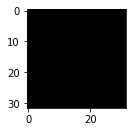

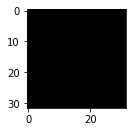

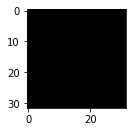

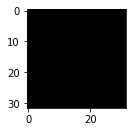

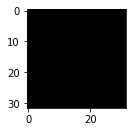

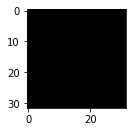

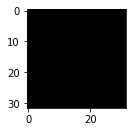

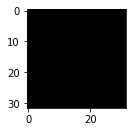

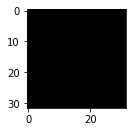

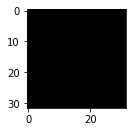

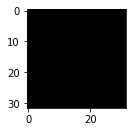

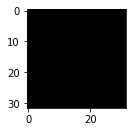

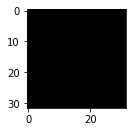

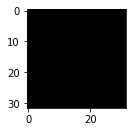

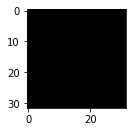

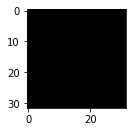

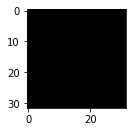

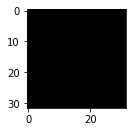

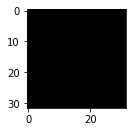

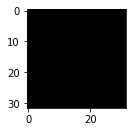

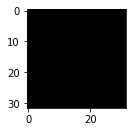

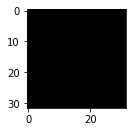

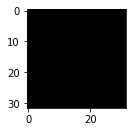

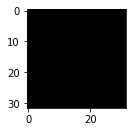

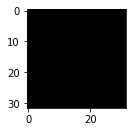

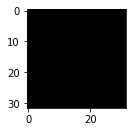

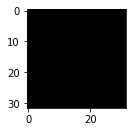

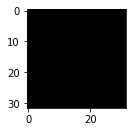

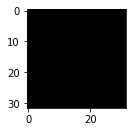

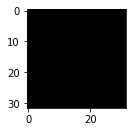

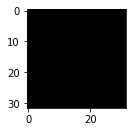

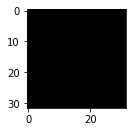

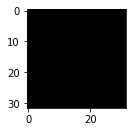

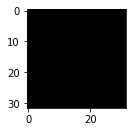

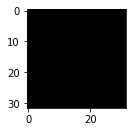

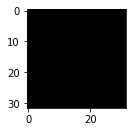

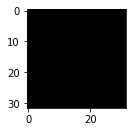

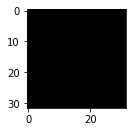

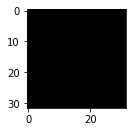

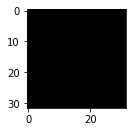

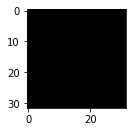

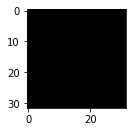

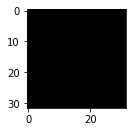

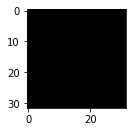

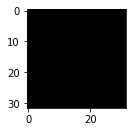

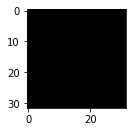

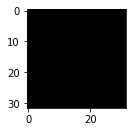

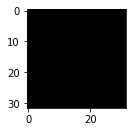

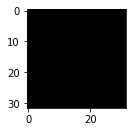

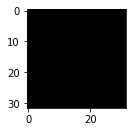

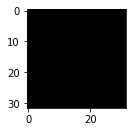

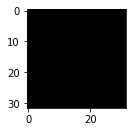

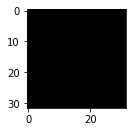

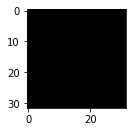

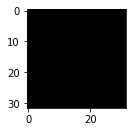

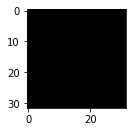

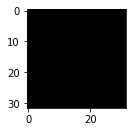

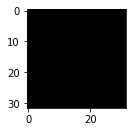

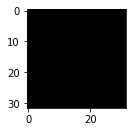

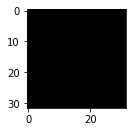

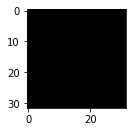

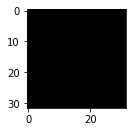

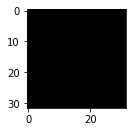

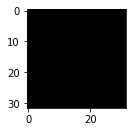

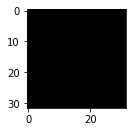

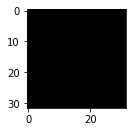

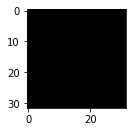

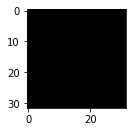

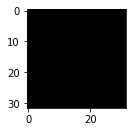

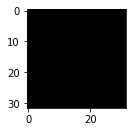

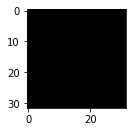

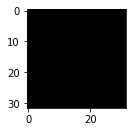

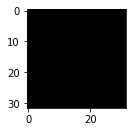

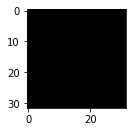

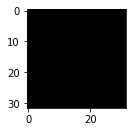

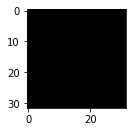

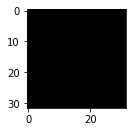

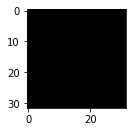

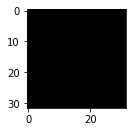

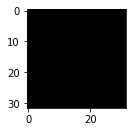

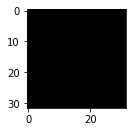

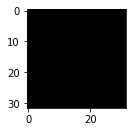

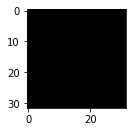

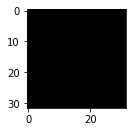

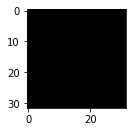

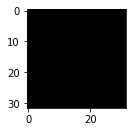

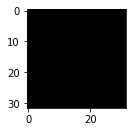

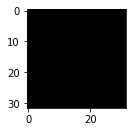

In [65]:
for i, j in enumerate(xdata):
    model.eval()
    data = torch.from_numpy(np.mean(np.array(j)/255, axis=2))
    labels = torch.from_numpy(np.array(ydata[i])/255)
    labels = Variable(labels)
    data = Variable(data)
#     optimizer.zero_grad()

    recon_batch, mu, logvar, z_space = model(data.float(), labels.float())
    t = recon_batch.detach().numpy()
    rec_img = t.reshape(-1,32,32)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(rec_img[0], cmap=plt.cm.gray)

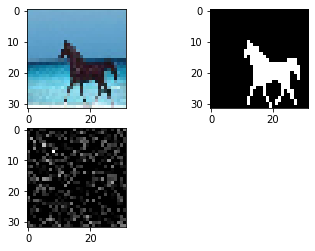

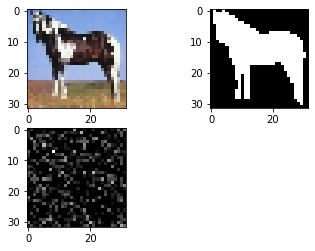

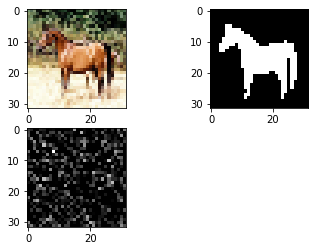

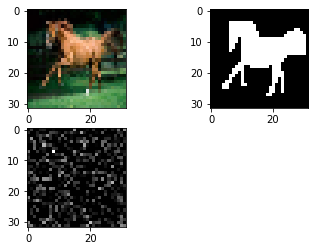

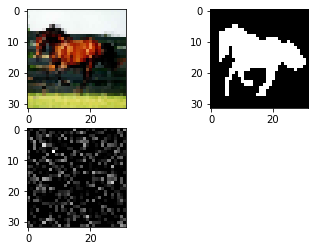

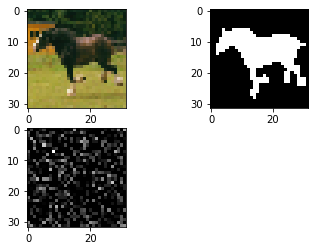

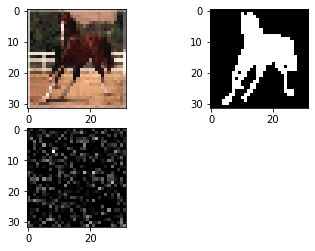

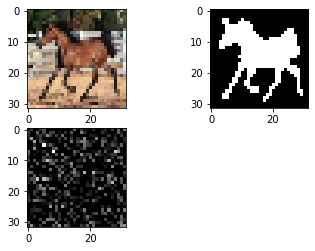

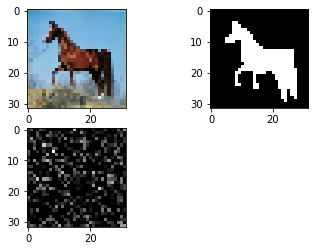

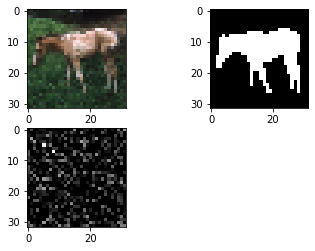

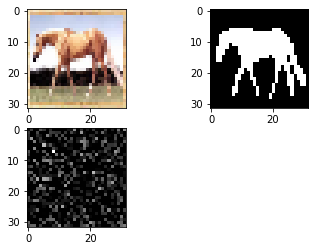

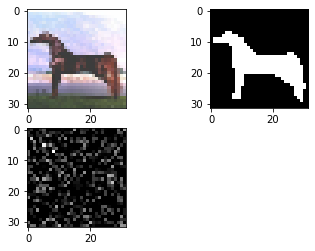

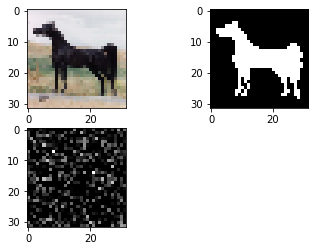

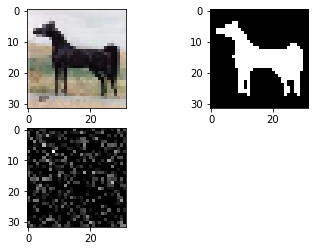

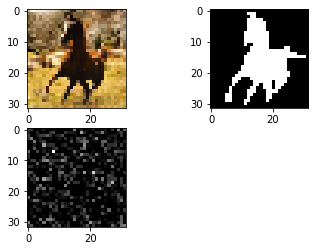

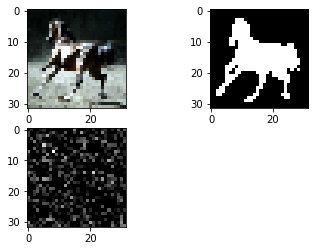

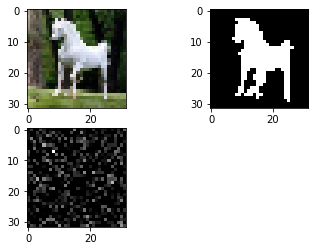

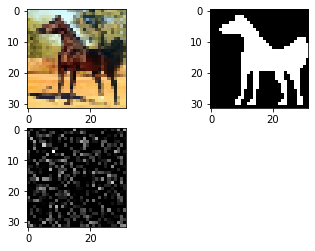

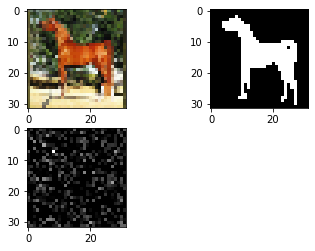

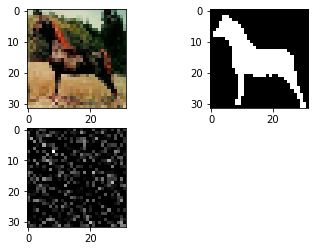

In [61]:
#first 20 horses picture
    
iter_ = 0

while iter_< 20:
    model.eval()
    y = torch.from_numpy(np.mean(np.array(xdata[iter_])/255, axis=2))
#     y = torch.from_numpy(np.array(ydata[iter_])/255)
    y = Variable(y)
    cond_ = y.float()
    recon_batch = model.decode(z_space, cond_.view(-1,32*32))
    t = recon_batch.detach().numpy()
    rec_img = t.reshape(-1,32,32)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(xtest[iter_])
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(ytest[iter_] , cmap=plt.cm.gray)
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(rec_img[0] , cmap=plt.cm.gray)
    
    iter_=iter_+1
    